# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings
import resource

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from statsmodels.robust.scale import mad

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

In [4]:
# Parameter Sweep for Hyperparameters
n_feature_pca = 300
n_feature_kept = 10
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'alpha': [10 ** x for x in range(-5, 2)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [5]:
%%time
path = os.path.join('..', 'download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 2min 48s, sys: 4.95 s, total: 2min 53s
Wall time: 2min 55s


In [6]:
%%time
path = os.path.join('..', 'download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 33s, sys: 3.99 s, total: 1min 37s
Wall time: 1min 38s


In [7]:
y = Y[GENE]

In [8]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [9]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Set aside 10% of the data for testing

In [10]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,530 features, 6,575 training samples, 731 testing samples'

## Reduce the dimensionality via Principal Component Analysis and Linear Discriminant Analysis

In [11]:
pca = PCA(n_components=n_feature_pca)
lda = LinearDiscriminantAnalysis(n_components=n_feature_kept)

## Define pipeline and Cross validation model fitting

In [12]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
clf = SGDClassifier(random_state=0, class_weight='balanced',
                    loss=param_fixed['loss'], penalty=param_fixed['penalty'])

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    StandardScaler(),  # Feature scaling
    pca, # Dimensionality reduction via PCA
    lda, # Dimensionality reduciton via LDA
    clf_grid)

In [13]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
print("The max memory usage is {:.3f} GB".format(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/(1024**3)))

The max memory usage is 4.957 GB
CPU times: user 10min 13s, sys: 15.8 s, total: 10min 29s
Wall time: 5min 32s


In [14]:
clf_grid.best_params_

{'alpha': 1e-05, 'l1_ratio': 0}

In [15]:
best_clf

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=0, shuffle=True,
       verbose=0, warm_start=False)

## Visualize hyperparameters performance

In [16]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## Process Mutation Matrix

In [17]:
cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
cv_score_df.head(2)

,alpha,fold,l1_ratio,score
0,0.00001,0,0.0,0.945005
1,0.00001,1,0.0,0.947590


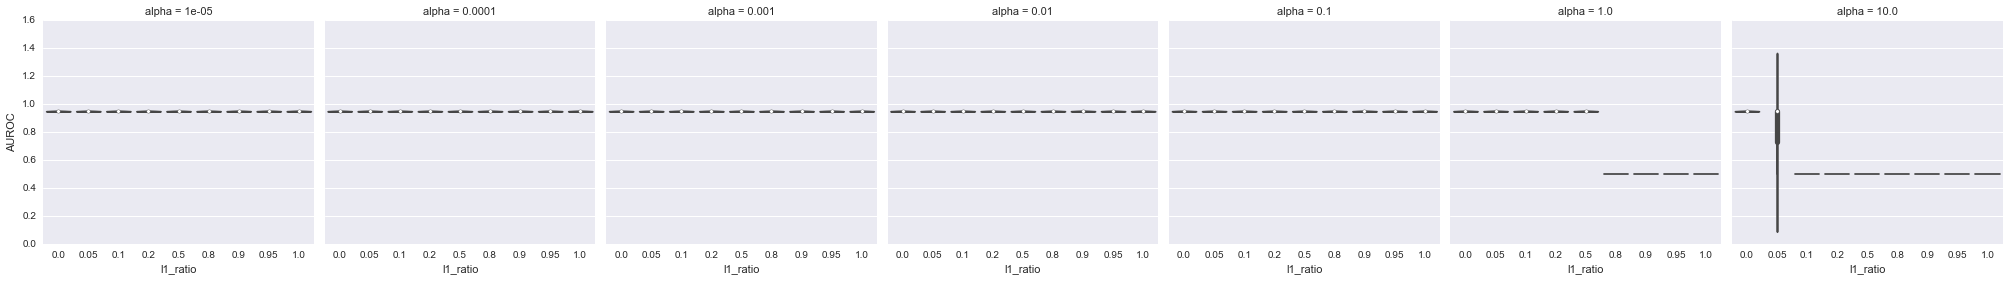

In [18]:
# Cross-validated performance distribution
facet_grid = sns.factorplot(x='l1_ratio', y='score', col='alpha',
    data=cv_score_df, kind='violin', size=4, aspect=1)
facet_grid.set_ylabels('AUROC');

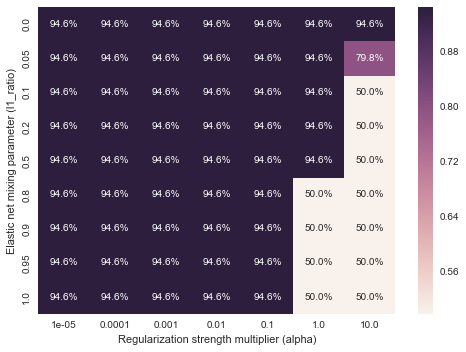

In [19]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_score_df, values='score', index='l1_ratio', columns='alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [20]:
y_pred_train = pipeline.decision_function(X_train)
y_pred_test = pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

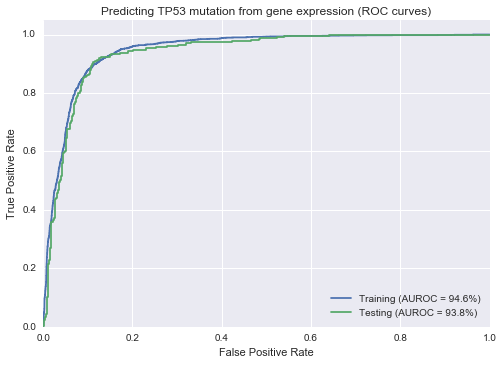

In [21]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## Investigate the predictions

In [22]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', pipeline.decision_function(X)),
    ('probability', pipeline.predict_proba(X)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [23]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-EI-6513-01,TCGA-EI-6513-01,1,0,21.435377,1.0,100.0%
TCGA-CK-5912-01,TCGA-CK-5912-01,0,0,19.463339,1.0,100.0%
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,19.094222,1.0,100.0%
TCGA-CQ-A4CI-01,TCGA-CQ-A4CI-01,0,0,19.046985,1.0,100.0%
TCGA-G2-A2EF-01,TCGA-G2-A2EF-01,1,0,18.318575,1.0,100.0%
TCGA-BA-5149-01,TCGA-BA-5149-01,0,0,17.999266,1.0,100.0%
TCGA-L5-A8NR-01,TCGA-L5-A8NR-01,0,0,17.902813,1.0,100.0%
TCGA-46-3765-01,TCGA-46-3765-01,0,0,17.706273,1.0,100.0%
TCGA-CV-6954-01,TCGA-CV-6954-01,0,0,16.745752,1.0,100.0%


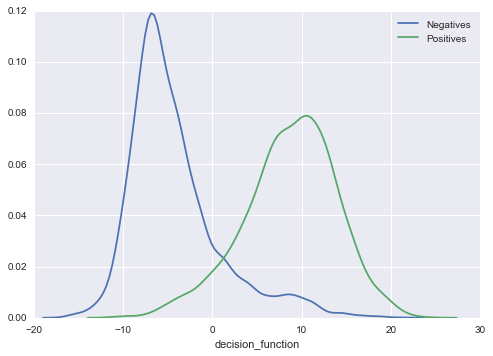

In [24]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

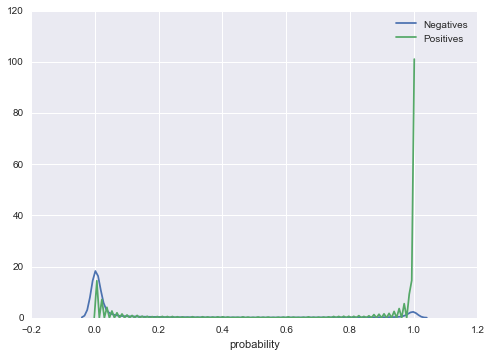

In [25]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')